# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split

In [33]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\Zjbro\OneDrive\Documents\GitHub\Solar-Panel-Capstone\data\processed


FileNotFoundError: [WinError 3] The system cannot find the path specified: '..\\data\\processed'

In [34]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,total_installed_price,rebate_or_grant,expansion_system,multiple_phase_system,tracking,ground_mounted,third_party_owned,self_installed,azimuth_1,...,module_model_1_missing,module_model_1_not_missing,solaredge_technologies,enphase_energy,inverter_manufacturer_1_missing,inverter_manufacturer_1_other,inverter_model_1_missing,iq7,se3,inverter_model_1_other
1480676,2.80,10472.0,0.0,0,0,0,0,1,0,127.0,...,0,1,0,1,0,0,0,0,0,1
1541293,7.44,22904.3,0.0,0,0,0,0,1,0,258.0,...,0,1,0,1,0,0,0,1,0,0
422316,9.60,3000.0,0.0,0,0,0,0,1,0,180.0,...,0,1,0,1,0,0,0,1,0,0
275862,2.56,8200.0,0.0,0,0,0,0,1,0,180.0,...,0,1,0,1,0,0,0,0,0,1
416176,4.10,36930.0,0.0,0,0,0,0,0,0,180.0,...,0,1,0,0,0,0,0,0,0,1


In [35]:
X_train.columns

Index(['system_size_dc', 'total_installed_price', 'rebate_or_grant',
       'expansion_system', 'multiple_phase_system', 'tracking',
       'ground_mounted', 'third_party_owned', 'self_installed', 'azimuth_1',
       'tilt_1', 'module_quantity_1', 'additional_modules', 'bipv_module_1',
       'bifacial_module_1', 'nameplate_capacity_module_1',
       'efficiency_module_1', 'inverter_quantity_1', 'additional_inverters',
       'micro_inverter_1', 'solar_storage_hybrid_inverter_1',
       'built_in_meter_inverter_1', 'dc_optimizer', 'inverter_loading_ratio',
       'year', 'month', 'state_AZ', 'state_CA', 'state_CO', 'state_CT',
       'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN', 'state_NH',
       'state_NM', 'state_NY', 'state_RI', 'state_TX', 'state_UT', 'state_WI',
       'technology_module_1_-1', 'technology_module_1_CIGS',
       'technology_module_1_CdTe', 'technology_module_1_Mono',
       'technology_module_1_Multi-c-Si', 'technology_module_1_Poly',
       'techno

In [36]:
y_train.head()

,price_per_kw
1480676,3740.000000
1541293,3078.534946
422316,312.500000
275862,3203.125000
416176,9007.317073


First I'm going to train a few dummy regression models to see how they performs and to set a benchmark of what I should consider a useful model.

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(y_train)

x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.8)

# Using the mean of the training set
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(x_tr, y_tr)
y_pred = dummy_mean.predict(x_te)
mean_squared_error(y_te, y_pred)

18659994.119095534

In [40]:
# Using the median of the training set
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(x_tr, y_tr)
y_pred = dummy_median.predict(x_te)
mean_squared_error(y_te, y_pred)

18689040.05151151

In [42]:
# One final dummy regressor using the 25th quantile of the training set
dummy_quantile = DummyRegressor(strategy="quantile", quantile = 0.25)
dummy_quantile.fit(x_tr, y_tr)
y_pred = dummy_quantile.predict(x_te)
mean_squared_error(y_te, y_pred)

19401284.279438186

Now that I have some base RMSE values that give me a cutoff for whether my models are effective or not, I'll begin with an ordinary least squares model.

In [43]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
mean_squared_error(y_te, y_pred)

15153828.928806404

OLS shows a relatively modest improvement over the dummy regressors. I want to check the coefficients to get a feel for how many there are, and their magnitudes.

In [44]:
ols.coef_

array([[-3.98909334e+02,  1.82969349e-01, -1.66644098e-01,
         6.03183078e+02, -1.41421637e+02, -1.68644515e+02,
        -7.53484039e+02,  9.98828560e+01,  5.96062974e+02,
        -1.64776978e-01,  8.98071262e+00, -8.90049345e+00,
        -5.66560711e+02, -1.16494531e+02, -6.90455889e+01,
        -7.13973503e+00,  1.61257836e+04, -7.11568446e+01,
         3.39745499e+03,  1.39811575e+03, -1.89680757e+02,
         2.44592980e+02,  5.69335659e+02, -1.48925595e+03,
        -4.04639557e+02, -5.05834404e+00,  1.79342153e+02,
        -1.88544751e+03,  1.16051174e+03, -6.94967220e+02,
         1.04235597e+03, -4.40673665e+02, -8.19604183e+02,
         7.02898177e+02,  4.61532847e+02,  5.24408155e+02,
        -6.61594207e+02, -5.21235960e+02, -4.79592996e+02,
         1.01243725e+03,  1.17002943e+03, -7.50399978e+02,
        -9.12246931e+02, -1.59161573e-12,  2.41016096e-11,
         5.70876724e+01,  4.42133536e+02,  1.69227527e+03,
        -1.27924955e+03, -2.77276307e+03,  7.99953300e+0

As expected, OLS produces a huge number of coefficients. I'll take a look at ridge regression to see if it will generate a better model with fewer coefficients.

In [45]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [49]:
parameters = {'alpha': sp_randFloat(0.01,1000)}
ridge = Ridge()
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 985.5612291321411}

In [50]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

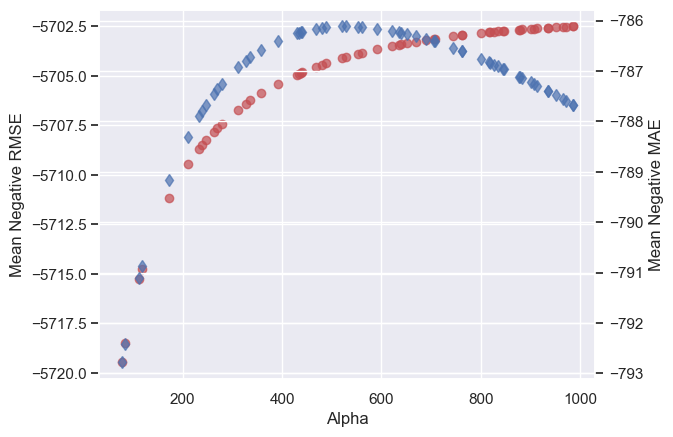

In [51]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an optimized alpha for the ridge regression I'll use it to model the test data and see how that performs.

In [ ]:
ridge=Ridge(alpha=268724222.15566957)
ridge.fit(x_tr, y_tr)
ridge.predict(x_te)
mean_squared_error(y_te, y_pred)

Next I'll identify the best alpha for a lasso regression to compare that against the OLS and ridge models.

In [13]:
parameters = {'alpha': sp_randInt(10000,10000000)}
lasso = linear_model.Lasso()
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 30737}

In [14]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
rand_lasso_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.077574,0.012496,0.006562,0.008036,8335804,{'alpha': 8335804},-13361.962430,-2786.260197,-2359.407877,-2855.894834,...,4368.047675,51,-1196.290792,-1432.941534,-1354.841766,-1439.336207,-1267.368255,-1338.155711,94.484696,51
1,0.092134,0.009743,0.011190,0.005248,1494405,{'alpha': 1494405},-5768.977169,-501.294841,-424.519955,-513.906097,...,2130.334525,9,-556.921088,-257.791112,-243.759232,-258.989799,-227.958264,-309.083899,124.428551,9
2,0.092303,0.025873,0.009394,0.007121,2225104,{'alpha': 2225104},-8589.774021,-745.311324,-631.165207,-764.011408,...,3172.363484,13,-829.228724,-383.288342,-362.422502,-385.041387,-338.971338,-459.790459,185.473668,13
3,0.085370,0.019805,0.010454,0.003319,5167699,{'alpha': 5167699},-12631.210890,-1727.989157,-1463.345523,-1771.209539,...,4443.456022,38,-1181.246298,-888.677734,-840.290878,-892.663234,-786.031672,-917.781963,137.298558,38
4,0.096303,0.024166,0.006858,0.001372,8232403,{'alpha': 8232403},-13338.079795,-2751.681907,-2330.153729,-2820.468812,...,4370.438983,50,-1195.708291,-1415.158491,-1338.043062,-1421.481925,-1251.643716,-1324.407097,89.110234,50


C:\Users\Zjbro\AppData\Local\Temp\ipykernel_23792\687083208.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000017707803CD0> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(axs, labs, loc=0)
C:\Users\Zjbro\AppData\Local\Temp\ipykernel_23792\687083208.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000017707859FD0> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(axs, labs, loc=0)


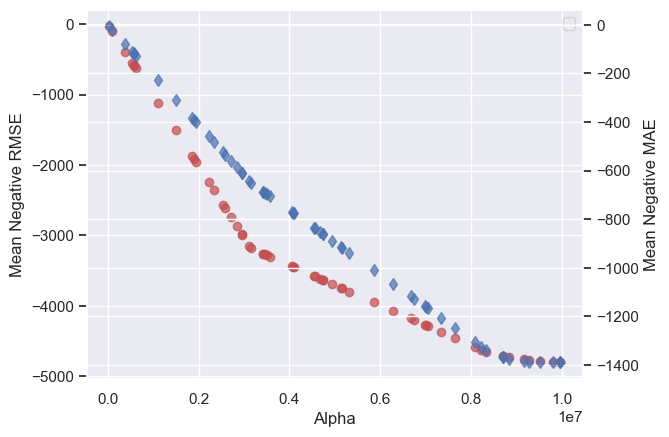

In [15]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

Next I'm going to take a look at random forest and see how that does modeling this dataset.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

parameters = {'n_estimators': sp_randInt(10,1000),
             'max_features': sp_randFloat(0.00001, 1.0),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1000,50000),
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 5,
 'max_features': 0.73253069814195,
 'min_samples_leaf': 1160,
 'n_estimators': 821}

In [23]:
rand_forest_params = pd.DataFrame(rand_forest.cv_results_)
rand_forest_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,1.017774,1.319576,0.087103,0.019562,5,0.446232,20709,251,"{'max_depth': 5, 'max_features': 0.44623174456...",-15392.581651,...,5390.254564,31,-1270.260988,-1061.596402,-1112.531924,-1101.541475,-1100.439661,-1129.274090,72.578781,35
1,0.552126,0.076370,0.090321,0.015911,4,0.533749,13108,442,"{'max_depth': 4, 'max_features': 0.53374939338...",-15392.582438,...,5390.243091,52,-1270.249854,-1061.748069,-1112.712455,-1101.835496,-1100.650228,-1129.439220,72.498666,51
2,0.756937,0.041443,0.124448,0.017434,8,0.033974,21109,483,"{'max_depth': 8, 'max_features': 0.03397417126...",-15392.580627,...,5390.251228,42,-1270.275500,-1061.600244,-1112.548139,-1101.661137,-1100.473718,-1129.311748,72.571115,42
3,1.210460,0.046845,0.089632,0.021228,4,0.725964,6194,394,"{'max_depth': 4, 'max_features': 0.72596416111...",-15341.027614,...,5509.567130,10,-882.103017,-685.932751,-713.332047,-693.137160,-696.054596,-734.111914,74.540849,11
4,0.270412,0.011976,0.021888,0.003473,7,0.606093,49397,92,"{'max_depth': 7, 'max_features': 0.60609318435...",-15392.578972,...,5390.245973,45,-1270.298991,-1061.681783,-1112.615850,-1101.779584,-1100.520269,-1129.379295,72.549175,45


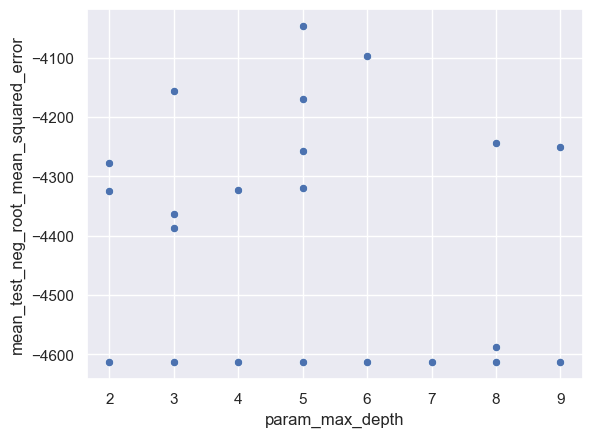

In [24]:
sns.scatterplot(data=rand_forest_params, x='param_max_depth', y='mean_test_neg_root_mean_squared_error')
plt.show()

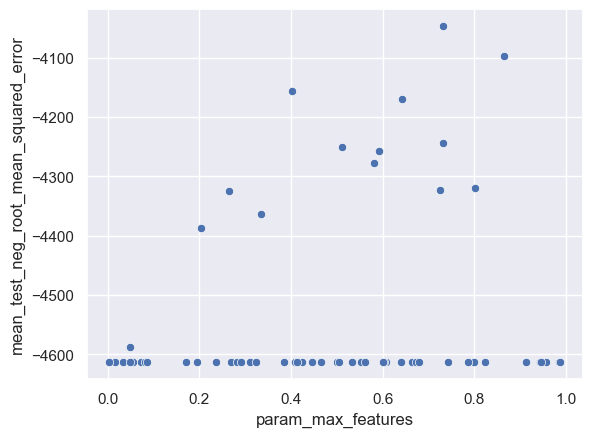

In [25]:
sns.scatterplot(data=rand_forest_params, x='param_max_features', y='mean_test_neg_root_mean_squared_error')
plt.show()

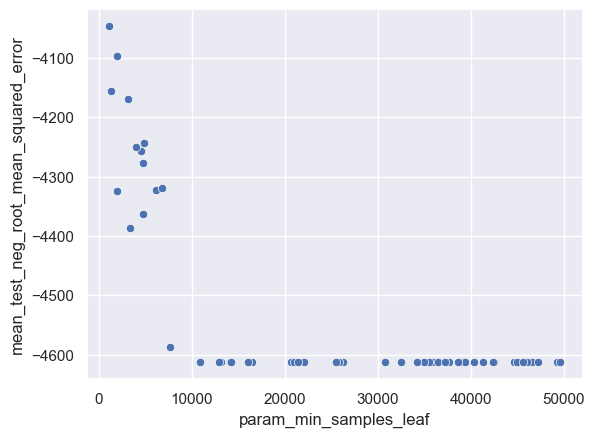

In [26]:
sns.scatterplot(data=rand_forest_params, x='param_min_samples_leaf', y='mean_test_neg_root_mean_squared_error')
plt.show()

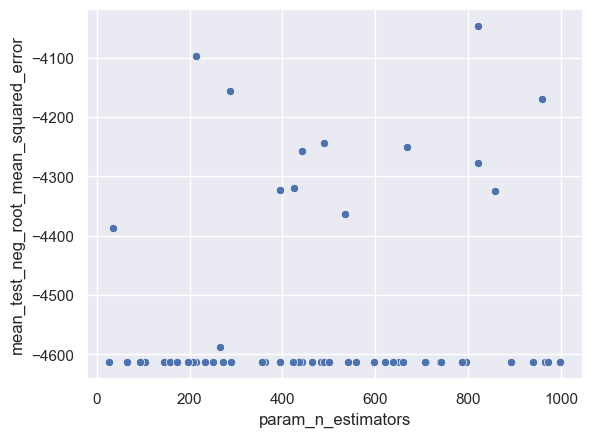

In [27]:
sns.scatterplot(data=rand_forest_params, x='param_n_estimators', y='mean_test_neg_root_mean_squared_error')
plt.show()

In [28]:
parameters = {
             'min_samples_leaf': sp_randInt(50,10000)
             }
forest = RandomForestRegressor(n_estimators=821, max_features=0.73253069814195, max_depth=5, n_jobs=-1, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'min_samples_leaf': 225}

In [30]:
opt_forest = RandomForestRegressor(n_estimators=821, max_features=0.73253069814195, min_samples_leaf=225, max_depth=5, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
mean_squared_error(y_te, y_pred)

2.060422798931258e-22